<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [ ]:
### Delete dataset exists
import os

folder_path = "./LITS17"
os.system(f"rm -rf {folder_path}")

0

In [4]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 245, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 245 (delta 12), reused 13 (delta 6), pack-reused 223 (from 1)
Receiving objects: 100% (245/245), 1.57 MiB | 18.02 MiB/s, done.
Resolving deltas: 100% (135/135), done.


In [5]:
from kltn.init.install_dependencies import install_packages
install_packages("./kltn")


In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer
from kltn.utils.metrics import EDiceLoss, EDiceLoss_Val
from kltn.models import unet3d, unet3d_cot, unet3d_cot_da, unet3d_rescot_da
from kltn.utils.visualize_results import visualize_results

In [7]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
log_path = "/content/drive/MyDrive/KLTN/logs"
LOGGER = init_logger(log_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS()

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.47% complete (down: 20728.5 kB/s up: 613.9 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.ph

## Load data

In [9]:
source_folder = "/content/LITS17"
full_train_dataset, val_dataset = get_datasets_lits(source_folder=source_folder, seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [10]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [11]:
for batch in train_loader:
    # Assuming your input data is a 4D tensor (batch_size, channels, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 2, 128, 128, 128])


## Visual data

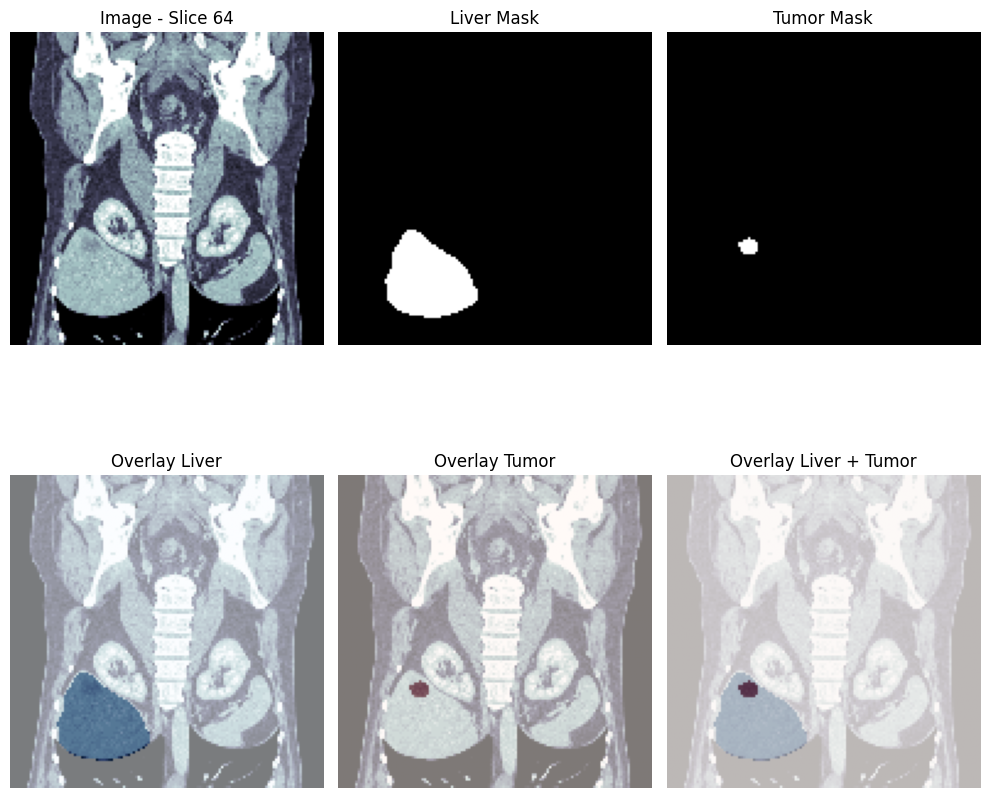

In [ ]:
import matplotlib.pyplot as plt

for batch in train_loader:
    image_sample = batch['image']
    label_sample = batch['label']  # Label có 2 lớp: Liver và Tumor

    slice_idx = image_sample.shape[2] // 2  # Lấy lát cắt giữa theo trục Depth (D)

    img_slice = image_sample[0, 0, slice_idx, :, :].numpy()  # Ảnh gốc (CT Scan)
    liver_label = label_sample[0, 0, slice_idx, :, :].numpy()  # Mask gan (Liver)
    tumor_label = label_sample[0, 1, slice_idx, :, :].numpy()  # Mask khối u (Tumor)

    fig, axes = plt.subplots(2, 3, figsize=(10, 10))  # Chia thành 2 hàng, 3 cột

    # Hàng 1: Ảnh gốc + Liver Mask + Tumor Mask
    axes[0, 0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0, 0].set_title(f"Image - Slice {slice_idx}")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(liver_label, cmap="gray")
    axes[0, 1].set_title(f"Liver Mask")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(tumor_label, cmap="gray")
    axes[0, 2].set_title(f"Tumor Mask")
    axes[0, 2].axis("off")

    # Hàng 2: Overlay Liver + Overlay Tumor + Overlay cả 2
    axes[1, 0].imshow(img_slice, cmap=plt.cm.bone)
    axes[1, 0].imshow(liver_label, cmap="Blues", alpha=0.5)  # Liver màu xanh
    axes[1, 0].set_title(f"Overlay Liver")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(img_slice, cmap=plt.cm.bone)
    axes[1, 1].imshow(tumor_label, cmap="Reds", alpha=0.5)  # Tumor màu đỏ
    axes[1, 1].set_title(f"Overlay Tumor")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(img_slice, cmap=plt.cm.bone)
    axes[1, 2].imshow(liver_label, cmap="Blues", alpha=0.5)
    axes[1, 2].imshow(tumor_label, cmap="Reds", alpha=0.5)
    axes[1, 2].set_title(f"Overlay Liver + Tumor")
    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()
    break  # Chỉ hiển thị batch đầu tiên


## Model

In [12]:
model = unet3d.UNet3D(in_channels=1, n_classes=2, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512498


## Training

In [13]:
start_epoch = 1
max_epochs = 1 # 100
batch_size = 1
val_every = 1

criterion = EDiceLoss().to(device)
criterian_val = EDiceLoss_Val().to(device)
metric = criterian_val.metric

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)


dice_acc = DiceMetric(include_background=True, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
path_save_model = "/content/drive/MyDrive/KLTN/code/weight"

In [22]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(val_acc_max, dice_liver, dice_tumor,
    dices_avg,loss_epochs, trains_epoch,
) = trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    loss_func = criterion,
    acc_func = dice_acc,
    criterian_val = criterian_val,
    metric = metric,
    scheduler = scheduler,
    batch_size = batch_size,
    max_epochs = max_epochs,
    start_epoch = start_epoch,
    val_every = val_every,
    path_save_model = path_save_model,
    logger = LOGGER,
    )

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/1 1/105 loss: 0.8858 time 3.56s
Epoch 1/1 2/105 loss: 0.8464 time 6.28s
Epoch 1/1 3/105 loss: 0.8354 time 10.00s
Epoch 1/1 4/105 loss: 0.8232 time 9.57s
Epoch 1/1 5/105 loss: 0.8176 time 11.00s
Epoch 1/1 6/105 loss: 0.8135 time 4.78s
Epoch 1/1 7/105 loss: 0.8044 time 1.29s
Epoch 1/1 8/105 loss: 0.8030 time 6.71s
Epoch 1/1 9/105 loss: 0.7951 time 1.37s
Epoch 1/1 10/105 loss: 0.7925 time 5.82s
Epoch 1/1 11/105 loss: 0.7928 time 14.53s
Epoch 1/1 12/105 loss: 0.7912 time 2.15s
Epoch 1/1 13/105 loss: 0.7901 time 5.69s
Epoch 1/1 14/105 loss: 0.7901 time 2.63s
Epoch 1/1 15/105 loss: 0.7897 time 11.39s
Epoch 1/1 16/105 loss: 0.7886 time 7.35s
Epoch 1/1 17/105 loss: 0.7882 time 4.89s
Epoch 1/1 18/105 loss: 0.7870 time 1.23s
Epoch 1/1 19/105 loss: 0.7821 time 1.49s
Epoch 1/1 20/105 loss: 0.7820 time 9.68s
Epoch 1/1 21/105 loss: 0.7795 time 2.18s
Epoch 1/1 22/105 loss: 0.7794 time 3.75s
Epoch 1/1 23/105 loss: 0.7733 time 3.78s
Epoch 1/1 24/105 loss: 0.7721 time 6.26s
Epoch 1/1 25/105 loss

Final training epochs: 1/1 ---[loss: 0.7138] ---[time 694.02s]
INFO:kltn.utils.logger:Final training epochs: 1/1 ---[loss: 0.7138] ---[time 694.02s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/1 105/105 loss: 0.7138 time 8.91s


Val 1/1 1/26, dice_liver: 0.159851, dice_tumor: 0.000000, time 10.38s
INFO:kltn.utils.logger:Val 1/1 1/26, dice_liver: 0.159851, dice_tumor: 0.000000, time 10.38s
Val 1/1 2/26, dice_liver: 0.353990, dice_tumor: 0.000000, time 1.68s
INFO:kltn.utils.logger:Val 1/1 2/26, dice_liver: 0.353990, dice_tumor: 0.000000, time 1.68s
Val 1/1 3/26, dice_liver: 0.322640, dice_tumor: 0.000000, time 2.64s
INFO:kltn.utils.logger:Val 1/1 3/26, dice_liver: 0.322640, dice_tumor: 0.000000, time 2.64s
Val 1/1 4/26, dice_liver: 0.313414, dice_tumor: 0.000000, time 2.49s
INFO:kltn.utils.logger:Val 1/1 4/26, dice_liver: 0.313414, dice_tumor: 0.000000, time 2.49s
Val 1/1 5/26, dice_liver: 0.335859, dice_tumor: 0.000000, time 2.14s
INFO:kltn.utils.logger:Val 1/1 5/26, dice_liver: 0.335859, dice_tumor: 0.000000, time 2.14s
Val 1/1 6/26, dice_liver: 0.321403, dice_tumor: 0.000000, time 7.22s
INFO:kltn.utils.logger:Val 1/1 6/26, dice_liver: 0.321403, dice_tumor: 0.000000, time 7.22s
Val 1/1 7/26, dice_liver: 0.2950

New best (0.000000 --> 0.147726). At epoch 1


## Visualize Results

In [14]:
import glob
print(glob.glob(f"{path_save_model}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


In [33]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from kltn.utils.utils import inference
from kltn.processing.postprocessing import post_trans

label_colors = ['yellow', 'red']  # Liver: Yellow, Tumor: Red
color_values = {'yellow': (255, 255, 0, 255), 'red': (255, 0, 0, 255)}
background_color = (0, 0, 0, 255)

def visualize_results(model, val_loader, weight_path, num_images, device):
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()

    stop = 0
    for val_val  in val_loader:
        stop+=1
        with torch.no_grad():
            val_input = val_val["image"].to(device)
            roi_size = (128, 128, 128)
            sw_batch_size = 4
            val_output = inference(val_input, model)
            print("val_output: ", val_output.shape)
            val_output = post_trans(val_output[0])
            print("val_output: ", val_output.shape)

            image_sample_np =  val_val["image"].detach().cpu().numpy()
            label_sample_np = val_val["label"].detach().cpu().numpy()
            val_output_np = val_output.detach().cpu().numpy()
            z_slice =  image_sample_np.shape[2] // 2

            # Plot input image
            plt.figure("Input Image", (6, 6))
            plt.title("Input Image")
            plt.imshow(image_sample_np[0, 0, z_slice], cmap="gray")
            plt.show()

            # Plot label
            plt.figure("Label", (12, 6))
            for i in range(2):
                plt.subplot(1, 2, i + 1)
                plt.title(f"Label channel {i}")
                plt.imshow(label_sample_np[0, i, z_slice], cmap="gray")
            plt.show()

            # Plot output
            plt.figure("Output", (12, 6))
            for i in range(2):
                plt.subplot(1, 2, i + 1)
                plt.title(f"Output channel {i}")
                plt.imshow(val_output_np[i, z_slice], cmap="gray")
            plt.show()

            # combine label
            image_sample_np_label = np.full((label_sample_np.shape[3], label_sample_np.shape[4], 4), background_color, dtype=np.uint8)
            num_channels_labels = label_sample_np.shape[1]
            for channel in range(num_channels_labels -1, -1, -1):
                label_channel = label_sample_np[0, channel, z_slice]

                label_color = label_colors[channel % len(label_colors)]
                color = color_values[label_color]

                label_mask = label_channel > 0
                image_sample_np_label[label_mask] = color


            # predict combine
            image_sample_np_predict = np.full((val_output_np.shape[2], val_output_np.shape[3], 4), background_color, dtype=np.uint8)
            num_channels_predict = val_output_np.shape[0]

            for channel in range(num_channels_predict -1, -1, -1):
                label_channel = val_output_np[channel, z_slice]
                label_color = label_colors[channel % len(label_colors)]

                color_value = color_values[label_color]
                label_mask = label_channel > 0

                image_sample_np_predict[label_mask] = color_value

            plt.show()

            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            ax[0].imshow(image_sample_np_label)
            ax[0].set_title("Composite Label")
            ax[1].imshow(image_sample_np_predict)
            ax[1].set_title("Composite Prediction")
            plt.show()

        if stop == num_images:
            break

val_output:  torch.Size([1, 2, 128, 128, 128])
val_output:  torch.Size([2, 128, 128, 128])


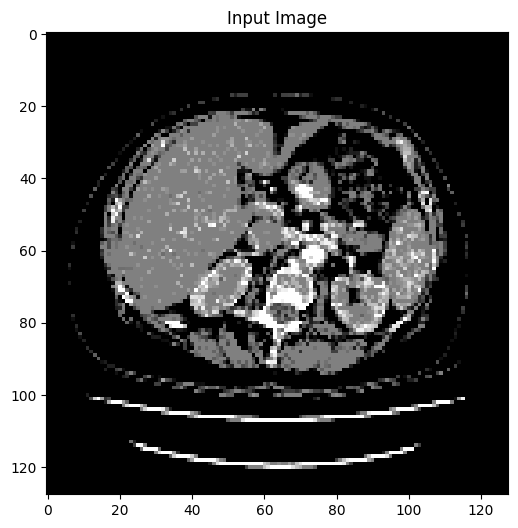

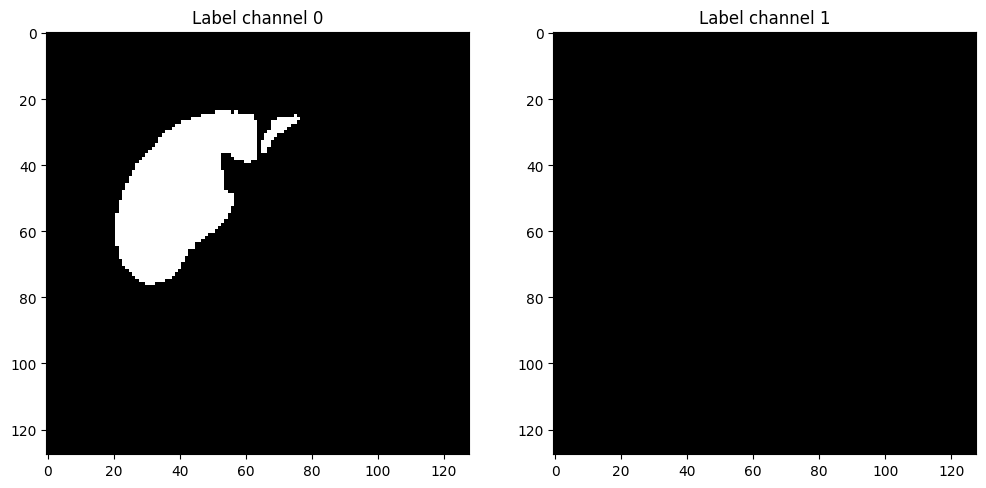

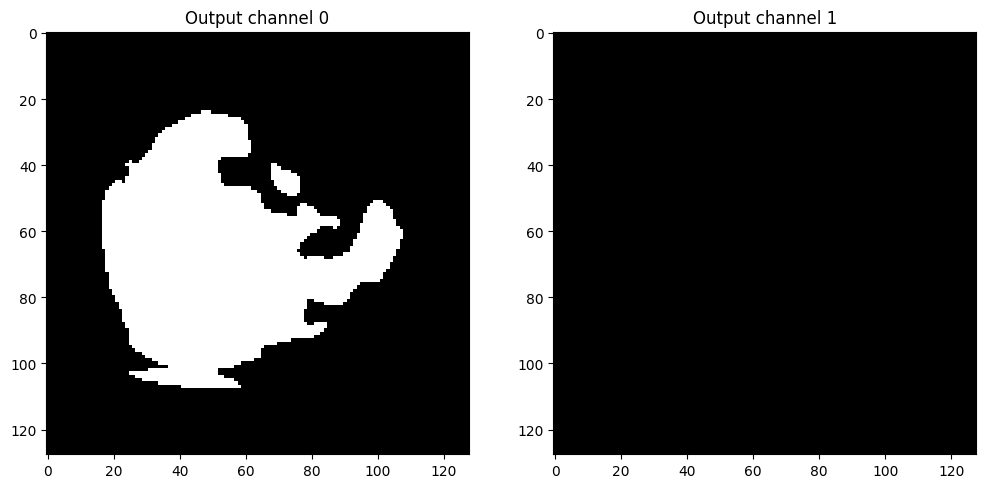

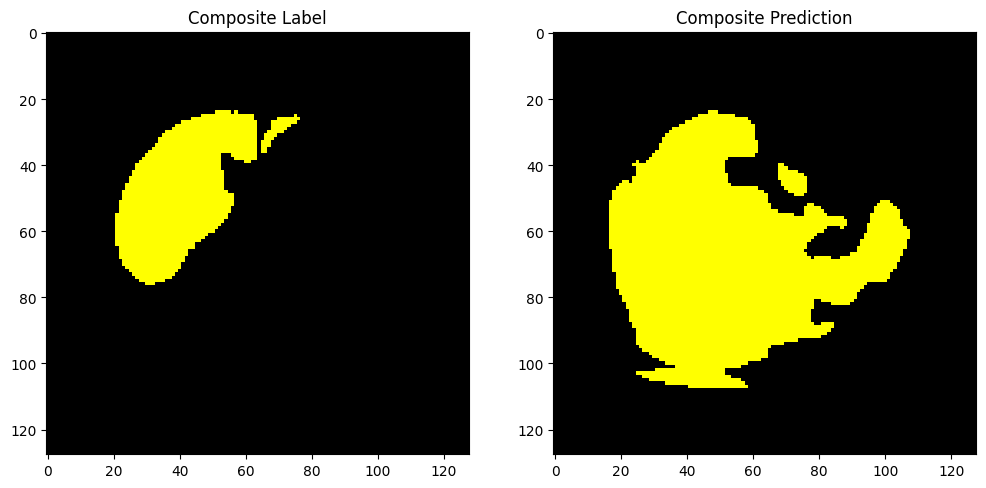

In [34]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)